In [1]:
import pickle
import numpy as np
import torch
from dynamics.dynamics import Dubins3D
from utils import modules
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


def plot_value_function(orig_opt, tMax, theta, sys, model):
    #override resolution for value function
    orig_opt.val_x_resolution = 500
    orig_opt.val_y_resolution = 500

    #define matrix of coordinates to pass to the DNN
    coords = torch.zeros(orig_opt.val_x_resolution*orig_opt.val_y_resolution, 4)
    coords[:, 0] = tMax
    coords[:, 3] = theta - np.pi/2
    x = np.linspace(-1, 1, orig_opt.val_x_resolution)
    y = np.linspace(-1, 1, orig_opt.val_y_resolution)
    xv, yv = np.meshgrid(x, y)
    coords[:, 1] = torch.from_numpy(xv.flatten())
    coords[:, 2] = torch.from_numpy(yv.flatten())

    #query the DNN for value function
    model_in = sys.coord_to_input(coords.cuda())
    results = model({'coords': model_in})
    model_in, model_out = results['model_in'].detach(), results['model_out'].squeeze(dim=-1).detach()
    values = sys.io_to_value(input=model_in, output=model_out)

    #reshape and plot
    values = values.reshape((orig_opt.val_x_resolution, orig_opt.val_y_resolution))
    
    BRT = 1*(values.detach().cpu().numpy().reshape(orig_opt.val_x_resolution, orig_opt.val_y_resolution).T <= 0)
    BRT = BRT - 1*(values.detach().cpu().numpy().reshape(orig_opt.val_x_resolution, orig_opt.val_y_resolution).T > 0)
    cmap = mcolors.LinearSegmentedColormap.from_list("mycmap", ["white", "white", "tab:blue"])

    plt.imshow(BRT, cmap=cmap,alpha=0.4, origin='lower', extent=(-1., 1., -1., 1.))
    plt.gca().set_aspect('equal', adjustable='box')
    return plt


# load original experiment settings
with open('C:\\Users\\javie\\Documents\\deepreach_feb24rel\\deepreach\\runs\\dubins3d_tutorial_run\\orig_opt.pickle', 'rb') as opt_file:
    orig_opt = pickle.load(opt_file)

#crete instance of the dynamics system
sys=Dubins3D(goalR=orig_opt.goalR, velocity=orig_opt.velocity, omega_max=orig_opt.omega_max, 
            angle_alpha_factor=orig_opt.angle_alpha_factor, set_mode=orig_opt.set_mode, freeze_model=orig_opt.freeze_model)

#create torch model and load it into the neural network, set it to evaluation mode
model = modules.SingleBVPNet(in_features=sys.input_dim, out_features=1, type=orig_opt.model, mode=orig_opt.model_mode,
                             final_layer_factor=1., hidden_features=orig_opt.num_nl, num_hidden_layers=orig_opt.num_hl)
model.cuda()
model.load_state_dict(torch.load('C:\\Users\\javie\\Documents\\deepreach_feb24rel\\deepreach\\runs\\dubins3d_tutorial_run\\training\\checkpoints\\model_current.pth'))
model.eval()
print('Model loaded successfully!') 

SingleBVPNet(
  (net): FCBlock(
    (net): Sequential(
      (0): Sequential(
        (0): BatchLinear(in_features=4, out_features=512, bias=True)
        (1): Sine()
      )
      (1): Sequential(
        (0): BatchLinear(in_features=512, out_features=512, bias=True)
        (1): Sine()
      )
      (2): Sequential(
        (0): BatchLinear(in_features=512, out_features=512, bias=True)
        (1): Sine()
      )
      (3): Sequential(
        (0): BatchLinear(in_features=512, out_features=512, bias=True)
        (1): Sine()
      )
      (4): Sequential(
        (0): BatchLinear(in_features=512, out_features=1, bias=True)
      )
    )
  )
)
Model loaded successfully!


In [2]:
from scipy.interpolate import RegularGridInterpolator
import mat73
from qpsolvers import solve_ls

# ------------------     MATLAB STUFF  ----------------------------------
def get_matlab_variables(mat_file_path):
    variables = mat73.loadmat(mat_file_path)
    #double gets converted to np array by default
    value_func_data = variables['Vx']
    lx_data = variables['lx'] 
    tau2 = variables['tau2']

    #Deriv is cell which gets converted into list of lists
    deriv_px_data = np.array(variables['Deriv'][0])
    deriv_px_data = deriv_px_data.squeeze()
    deriv_py_data = np.array(variables['Deriv'][1])
    deriv_py_data = deriv_py_data.squeeze()
    deriv_th_data = np.array(variables['Deriv'][2])
    deriv_th_data = deriv_th_data.squeeze()

    #g is struct whic gets converted into dic
    #vs is cell which give a list
    x_coord=np.array(variables['g']['vs'][0])
    y_coord=np.array(variables['g']['vs'][1])
    th_coord=np.array(variables['g']['vs'][2])
    x_coord = x_coord.squeeze()
    y_coord = y_coord.squeeze()
    th_coord = th_coord.squeeze()

    matlab_var_dict = dict( value_func_data=value_func_data,
                            lx_data=lx_data,
                            deriv_px_data=deriv_px_data,
                            deriv_py_data=deriv_py_data,
                            deriv_th_data=deriv_th_data,
                            x_coord=x_coord,
                            y_coord=y_coord,
                            th_coord=th_coord,
                            tau2=tau2
                           )
    return matlab_var_dict

def get_value_func_eval_function(matlab_var_dict):
   val_func_eval = RegularGridInterpolator(( matlab_var_dict['x_coord'], matlab_var_dict['y_coord'], matlab_var_dict['th_coord']), matlab_var_dict['value_func_data'] ,  bounds_error=False, fill_value=None)
   return val_func_eval

def get_lx_eval_function(matlab_var_dict):
   lx_eval = RegularGridInterpolator(( matlab_var_dict['x_coord'], matlab_var_dict['y_coord']), matlab_var_dict['lx_data'] ,  bounds_error=False, fill_value=None)
   return lx_eval


def get_deriv_posx_function(matlab_var_dict):
   deriv_posx_eval = RegularGridInterpolator(( matlab_var_dict['x_coord'], matlab_var_dict['y_coord'], matlab_var_dict['th_coord'] ), matlab_var_dict['deriv_px_data'] ,  bounds_error=False, fill_value=None)
   return deriv_posx_eval

def get_deriv_posy_function(matlab_var_dict):
   deriv_posy_eval = RegularGridInterpolator(( matlab_var_dict['x_coord'], matlab_var_dict['y_coord'], matlab_var_dict['th_coord'] ), matlab_var_dict['deriv_py_data'] ,  bounds_error=False, fill_value=None)
   return deriv_posy_eval

def get_deriv_th_function(matlab_var_dict):
   deriv_th_eval =   RegularGridInterpolator(( matlab_var_dict['x_coord'], matlab_var_dict['y_coord'], matlab_var_dict['th_coord'] ), matlab_var_dict['deriv_th_data'] ,  bounds_error=False, fill_value=None)
   return deriv_th_eval

def get_gradient(deriv_posx_eval,deriv_posy_eval,deriv_th_eval, state):
    dx = deriv_posx_eval(state)
    dy = deriv_posy_eval(state)
    dth = deriv_th_eval(state)
    #concatenate the gradients
    dVx = np.array([dx,dy,dth])
    #transpose dVx
    dVx = np.transpose(dVx)
    return dVx

def get_opt_control( deriv_th_eval, state, angleMax, u_mode = 'max'):
    th_deriv = deriv_th_eval(state)
    if u_mode == 'max':

        opt_angle = angleMax * ( th_deriv >= 0 ) + (-angleMax) * ( th_deriv < 0 )
    else:
        raise NotImplementedError
    return opt_angle


#---------------other functions------------------------------------------------------------
def dubins_dyn(state, u, d, v):
    x, y, th = state
    x_dot = v * np.cos(th)
    y_dot = v * np.sin(th)
    th_dot = u
    return np.array([x_dot, y_dot, th_dot])

def P_controller_th(th,th_setpoint, Kp, u_range):
    u = Kp*(th_setpoint-th)
    u = np.clip(u, -u_range, u_range)
    return u

def fx(state, v):
    th = state[2]
    fx = np.array([v * np.cos(th), v * np.sin(th), 0],ndmin=2)
    return fx.T

gx=np.array([[0],
             [0],
             [1]]) #ctrl mat



#---------------------- Load MATLAB ---------------------------------------------------------
#v1 N=[101,101,101], v2 N=[201,201,101]
matlab_var_dict= get_matlab_variables('C:\\Users\\javie\\Documents\\deepreach_feb24rel\\brt_dubins3D_match_deepreach_v2.mat')
data = matlab_var_dict['value_func_data']
data_lx = matlab_var_dict['lx_data']
val_fun = get_value_func_eval_function(matlab_var_dict)
lx_fun = get_lx_eval_function(matlab_var_dict)

deriv_x_eval = get_deriv_posx_function(matlab_var_dict)
deriv_y_eval = get_deriv_posy_function(matlab_var_dict)
deriv_th_eval = get_deriv_th_function(matlab_var_dict)

print('MATLAB data loaded successfully!')

MATLAB data loaded successfully!


In [23]:
# example of how to query the value for a single state
s0 = torch.tensor([0., 0., 0., 0.])
results = model({'coords': sys.coord_to_input(s0[None].cuda())})
model_in, model_out = results['model_in'], results['model_out']
val0 = sys.io_to_value(input=model_in, output=model_out)[0]
dval0 = sys.io_to_dv(input=model_in, output=model_out)[0]
print('Value:', val0) #as its the center of the target, the value should be close to -goalR
print('Value Gradient:', dval0)


#trajectory example
tMax = orig_opt.tMax
dt = 0.01
num_steps = 200
e = 0.01

s0 = torch.tensor([0.0, -0.8, np.pi/2]).cuda()
s_hist = [s0]
val_hist = []

for i in range(num_steps):
    s = s_hist[-1]
    s = s[None].cuda() #batch size 1
    #query the DNN for value function and its gradient
    model_in = torch.cat([torch.tensor([[tMax]]).cuda(),s], dim=-1)
    results = model({'coords': sys.coord_to_input(model_in)})
    model_in, model_out = results['model_in'], results['model_out']
    val0 = sys.io_to_value(input=model_in, output=model_out)[0]
    dval = sys.io_to_dv(input=model_in, output=model_out).squeeze()
    # print('val:', val0)
    # print('dval:', dval)
    dvds = dval[1:]
    dvds = dvds[None].cuda() #batch size 1
    # print('dvds:', dvds)
    #if the value is below treshold we engage the optimal control
    u_nom = P_controller_th(s[0,2].cpu().detach().numpy(), np.pi/2, 10, orig_opt.omega_max)
    if val0 < e:
        # min_u (u-unom)^2
        # s.t. Gu<=h  and lb<=u<=ub 
        R = np.array([[1.0]])
        S = np.array([[u_nom]])
        deriv_now=dvds.cpu().detach().numpy()
        G= -deriv_now @ gx
        opt_d = 0
        h= deriv_now @ fx(s[0,:].cpu().detach().numpy(),orig_opt.velocity) #+ deriv_now @ hx @ opt_d
        lb = np.array([[-orig_opt.omega_max]])
        ub = np.array([[orig_opt.omega_max]])
        u = solve_ls(R, S, G=G, h=h, lb=lb, ub=ub, solver="daqp")       
        if u is None:
            u=sys.optimal_control(state=s, dvds=dvds)
    else:
        u = u_nom

    u = torch.tensor([[u]], device='cuda:0')
    # print('control:', u)
    d = 0 
    dsdt = sys.dsdt(s, u, d).squeeze()
    # print('dsdt:', dsdt)
    s = s + dt*dsdt
    s = s.squeeze()
    # print('s:', s)
    s_hist.append(s)
    val_hist.append(val0.squeeze())


Value: tensor([-0.2554], device='cuda:0', grad_fn=<SelectBackward0>)
Value Gradient: tensor([[-0.2456,  0.0212, -0.4038,  0.0026]], device='cuda:0',
       grad_fn=<SelectBackward0>)


C:\Users\javie\AppData\Local\Temp\ipykernel_9536\1787587173.py:54: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:277.)
  u = torch.tensor([[u]], device='cuda:0')


In [24]:
s0_matlab = np.array([0.0, -0.8, np.pi/2])
#trajectory example Matlab
tMax = orig_opt.tMax
dt = 0.01
num_steps = 200
e = 0.01

s_hist_matlab = [s0_matlab]
val_hist_matlab = []

for i in range(num_steps):
    s= s_hist_matlab[-1]
    val = val_fun(s)
    dvdth = deriv_th_eval(s)
    u_nom = P_controller_th(s[2], np.pi/2, 10, orig_opt.omega_max)
    if val < e:
        #u = get_opt_control(deriv_th_eval, S, orig_opt.omega_max).squeeze()
        # min_u (u-unom)^2\n        # s.t. Gu<=h  and lb<=u<=ub 
        R = np.array([[1.0]])
        S = np.array([[u_nom]])
        deriv_now=get_gradient(deriv_x_eval,deriv_y_eval,deriv_th_eval, s)
        G= -deriv_now @ gx
        opt_d = 0
        h= deriv_now @ fx(s,orig_opt.velocity) #+ deriv_now @ hx @ opt_d
        lb = np.array([[-orig_opt.omega_max]])
        ub = np.array([[orig_opt.omega_max]])
        u = solve_ls(R, S, G=G, h=h, lb=lb, ub=ub, solver="daqp")
        if u is None:
            u = get_opt_control(deriv_th_eval, s, orig_opt.omega_max).squeeze()            
    else:
        u = u_nom

    d = 0 
    dsdt = dubins_dyn(s, u.squeeze(), d, orig_opt.velocity)

    s = s + dt*dsdt
    s = s.squeeze()
    s_hist_matlab.append(s)
    val_hist_matlab.append(val)

C:\Users\javie\AppData\Local\Temp\ipykernel_9536\1533971738.py:21: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in CP2.collections:
C:\Users\javie\AppData\Local\Temp\ipykernel_9536\1533971738.py:122: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  values[i] = val_fun([s_boundary_matlab[0] , s_boundary_matlab[1], theta[i]+s_boundary_matlab[2]])


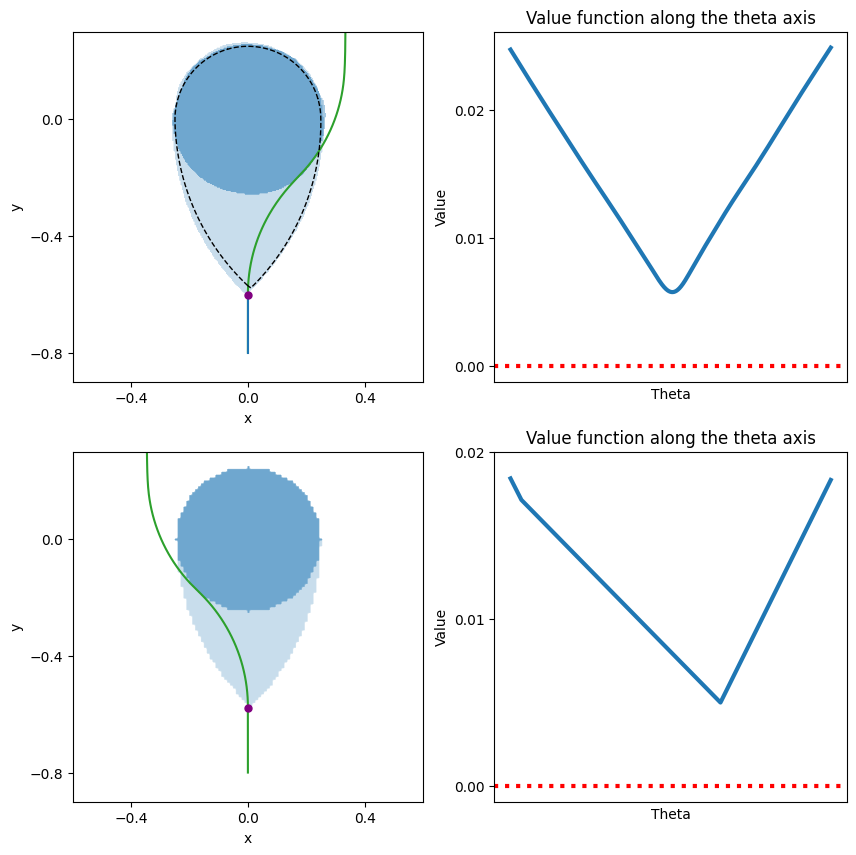

In [25]:
# Create a figure
plt.figure(figsize=(10, 10))

# Create the first subplot
plt.subplot(2, 2, 1)
#plot trajectory
s_hist_stack = torch.stack(s_hist)
plt.plot(s_hist_stack[:,0].cpu().detach().numpy(), s_hist_stack[:,1].cpu().detach().numpy(),color='tab:green')
#plt.plot(-s_hist_stack[:,0].cpu().detach().numpy(), s_hist_stack[:,1].cpu().detach().numpy(),color='tab:green')
plt.plot(s_hist_stack[:33,0].cpu().detach().numpy(), s_hist_stack[:33,1].cpu().detach().numpy(),color='tab:blue')
#plot converged (tMax) BRT over xy plane at a given angle 
plt = plot_value_function(orig_opt=orig_opt, tMax=tMax, theta=np.pi/2, sys=sys, model=model)
#plot obstacle set
plt = plot_value_function(orig_opt=orig_opt, tMax=0, theta=np.pi/2, sys=sys, model=model)

#plot the helperOC value function
th_idx = np.argmin(np.abs(matlab_var_dict['th_coord'] - np.pi/2))
data2 = data[:,:,th_idx] #slice the value function at the closest theta
data2 = data2.transpose()
CP2 = plt.contour(matlab_var_dict['x_coord'],matlab_var_dict['y_coord'],data2,0)
for c in CP2.collections:
    c.set_edgecolor("black")
    c.set_linewidth(1.0)
    c.set_linestyle('dashed')
    c.set_label("helperOC")

#find first value below treshold in the value history
idx = 0
for i in range(len(val_hist)):
    if val_hist[i] < e:
        idx = i
        break
#grab the state at the first negative value and plot it
s_boundary = s_hist_stack[idx]
plt.plot(s_boundary[0].cpu().detach().numpy(), s_boundary[1].cpu().detach().numpy(), 'o',color='purple', markersize=5)
plt.xlabel('x')
plt.ylabel('y')
plt.yticks([-0.8,-0.4,0.0])
plt.xticks([-0.4,0.0,0.4])
plt.xlim([-0.6, 0.6])
plt.ylim([-0.9, 0.3])

############################################################################################################################################################
# Create the second subplot
plt.subplot(2, 2, 2)
#define matrix of coordinates to pass to the DNN
th_points = 1000
coords = torch.zeros(th_points, 4)
coords[:, 0] = tMax
coords[:, 1] = s_boundary[0]
coords[:, 2] = s_boundary[1]
theta = np.linspace(-0.05, 0.05, th_points)
coords[:, 3] = torch.from_numpy(theta) + s_boundary[2].cpu()
#query the DNN for value function
model_in = sys.coord_to_input(coords.cuda())
results = model({'coords': model_in})
model_in, model_out = results['model_in'].detach(), results['model_out'].squeeze(dim=-1).detach()
values = sys.io_to_value(input=model_in, output=model_out)

#plot the value function along the theta axis
plt.plot(theta, values.cpu().detach().numpy(), color='tab:blue', linewidth=3.0)

plt.axhline(0, color='red', linestyle='dotted', linewidth=3.0)
#plt.axvline(0, color='red', linestyle='dotted', linewidth=0.75)
plt.xlabel('Theta')
plt.ylabel('Value')
plt.yticks([0,0.01,0.02])
plt.xticks([])
plt.title('Value function along the theta axis')

############################################################################################################################################################
plt.subplot(2, 2, 3)
#plot matlab trajectory
s_hist_matlab = np.array(s_hist_matlab)
plt.plot(s_hist_matlab[:,0], s_hist_matlab[:,1],color='tab:green')
#plt.plot(-s_hist_matlab[:,0], s_hist_matlab[:,1],color='tab:green')

# Plot the helperOC value function
th_idx = np.argmin(np.abs(matlab_var_dict['th_coord'] - np.pi/2))
data2 = data[:,:,th_idx]  # Slice the value function at the closest theta
data2 = data2.transpose()
BRT = 1*(data2 <= 0)
BRT = BRT - 1*(data2 > 0)
# Create the image plot
cmap = mcolors.LinearSegmentedColormap.from_list("mycmap", ["white", "white", "tab:blue"])
plt.imshow(BRT, extent=[matlab_var_dict['x_coord'].min(), matlab_var_dict['x_coord'].max(), matlab_var_dict['y_coord'].min(), matlab_var_dict['y_coord'].max()], origin='lower', cmap=cmap,alpha=0.4)

#repeat for obstacle set
th_idx = np.argmin(np.abs(matlab_var_dict['th_coord'] - 0))
data3 = data_lx  # Slice the value function at the closest theta
data3 = data3.transpose()
BRT = 1*(data3 <= 0)
BRT = BRT - 1*(data3 > 0)
# Create the image plot
plt.imshow(BRT, extent=[matlab_var_dict['x_coord'].min(), matlab_var_dict['x_coord'].max(), matlab_var_dict['y_coord'].min(), matlab_var_dict['y_coord'].max()], origin='lower', cmap=cmap,alpha=0.4)

#find first value below treshold in the value history
idx_matlab = 0
for i in range(len(val_hist_matlab)):
    if val_hist_matlab[i] < e:
        idx_matlab = i
        break
#grab the state at the first negative value and plot it
s_boundary_matlab = s_hist_matlab[idx_matlab]
plt.plot(s_boundary_matlab[0], s_boundary_matlab[1], 'o',color='purple', markersize=5)
plt.xlabel('x')
plt.ylabel('y')
plt.yticks([-0.8,-0.4,0.0])
plt.xticks([-0.4,0.0,0.4])
plt.xlim([-0.6, 0.6])
plt.ylim([-0.9, 0.3])


############################################################################################################################################################
plt.subplot(2, 2, 4)

th_points = 1000
theta = np.linspace(-0.05, 0.05, th_points)
#plot the helperOC value function along the theta axis
values = np.zeros(th_points)
for i in range(th_points):
    values[i] = val_fun([s_boundary_matlab[0] , s_boundary_matlab[1], theta[i]+s_boundary_matlab[2]])
plt.plot(theta, values, color='tab:blue', linewidth=3.0)

plt.axhline(0, color='red', linestyle='dotted', linewidth=3.0)
plt.xlabel('Theta')
plt.ylabel('Value')
plt.yticks([0,0.01,0.02])
plt.xticks([])
plt.title('Value function along the theta axis')


plt.savefig('plot.png', transparent=True)
#show the plot
plt.show()


In [18]:
print(_ih[:500])

['', 'import pickle\nimport numpy as np\nimport torch\nfrom dynamics.dynamics import Dubins3D\nfrom utils import modules\nimport matplotlib.pyplot as plt\nimport matplotlib.colors as mcolors\n\n\ndef plot_value_function(orig_opt, tMax, theta, sys, model):\n    #override resolution for value function\n    orig_opt.val_x_resolution = 500\n    orig_opt.val_y_resolution = 500\n\n    #define matrix of coordinates to pass to the DNN\n    coords = torch.zeros(orig_opt.val_x_resolution*orig_opt.val_y_resolution, 4)\n    coords[:, 0] = tMax\n    coords[:, 3] = theta - np.pi/2\n    x = np.linspace(-1, 1, orig_opt.val_x_resolution)\n    y = np.linspace(-1, 1, orig_opt.val_y_resolution)\n    xv, yv = np.meshgrid(x, y)\n    coords[:, 1] = torch.from_numpy(xv.flatten())\n    coords[:, 2] = torch.from_numpy(yv.flatten())\n\n    #query the DNN for value function\n    model_in = sys.coord_to_input(coords.cuda())\n    results = model({\'coords\': model_in})\n    model_in, model_out = results[\'model_in\